### Import data set (using sklearn for this)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False ,parser = "pandas"
)

X = X/ 255.0
y_enc = OneHotEncoder().fit_transform(y[:, np.newaxis]).toarray()

np.random.seed(42)
train_samples = 6000
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, train_size=train_samples, test_size=10000, random_state = 42
)
val_samples = 1000
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_samples, random_state = 42
)

 

In [3]:
len(y_val)

1000

Lets look at an example

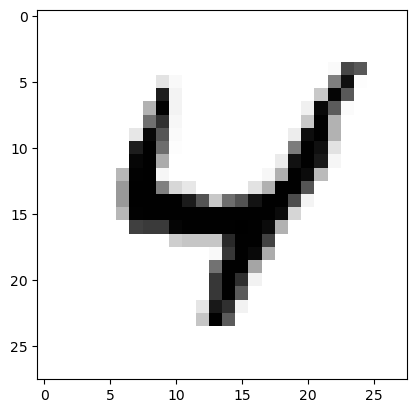

In [4]:
example = np.reshape(X_train[3],[28,28])
plt.imshow(example, cmap='Greys')

In [5]:
y_train[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

Define the activations

In [3]:
def relu(x):
    return (x > 0) * x         

def relu2deriv(output):
    return output>0            

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x/np.sum(e_x, axis = 1) 

In [4]:
import warnings
warnings.filterwarnings("error")

 This could be improved a lot (and more hypertuning could be done)
 
* better models!

But this serves for what I want to look at here

In [7]:

class SimpMNISTNet:
   def __init__(self, hidden_size):
      self.hidden_size = hidden_size
      self.weights_0_1 = 2*np.random.random((28*28,hidden_size)) - 1
      self.weights_1_2 = 2*np.random.random((hidden_size,10)) - 1
      self.bias_1 = np.zeros([1,hidden_size])
      self.bias_2 = np.zeros([1,10])

   def predict(self, X):
      layer_1 = relu(np.dot(X,self.weights_0_1) + self.bias_1)
      return softmax(np.dot(layer_1,self.weights_1_2) + self.bias_2)
   
   def single_epoch_train(self, X, y, alpha, batch_size):
      eps = 10**-9
      indices = [*range(len(y))]
      np.random.shuffle(indices)
      batch_ind = [indices[i:i+batch_size] for i in range(0, len(indices), batch_size)]
      layer_2_error = 0
      for batch in batch_ind:
         layer_2_delta_b = np.zeros([1,10])
         layer_1_2_delta_w = np.zeros([self.hidden_size,10])
         layer_1_delta_b = np.zeros([1,self.hidden_size])
         layer_0_1_delta_w = np.zeros([28*28,self.hidden_size])
         # TODO: Vectorize this
         for i in batch:
            layer_0 = X[i:i+1]
            layer_1 = relu(np.dot(layer_0,self.weights_0_1) + self.bias_1)
            layer_2 = softmax(np.dot(layer_1,self.weights_1_2) + self.bias_2)
            layer_2_error -= y[i:i+1].dot(np.log(layer_2 + eps).T)
            #layer_2_delta =  -y[i:i+1]*(1-layer_2)
            layer_2_delta =   layer_2 - y[i:i+1]
            layer_1_delta = layer_2_delta.dot(self.weights_1_2.T)*relu2deriv(layer_1)
            layer_1_delta_b += layer_1_delta
            layer_2_delta_b += layer_2_delta
            layer_1_2_delta_w += layer_1.T.dot(layer_2_delta)
            layer_0_1_delta_w += layer_0.T.dot(layer_1_delta)
         self.weights_1_2 -= alpha * layer_1_2_delta_w /len(batch)
         self.bias_2 -= alpha*layer_2_delta_b /len(batch)      
         self.weights_0_1 -= alpha * layer_0_1_delta_w /len(batch)
         self.bias_1 -= alpha*layer_1_delta_b / len(batch)
      return layer_2_error


   def sgd(self, X, y, X_val, y_val, alpha, batch_size, epochs):
      for iteration in range(epochs):
         error = self.single_epoch_train(X, y, alpha, batch_size)
         if((iteration + 1) % 10 ==0):
             print(f"Error: {error} -- Val error: {self.evaluate(X_val, y_val)}")


   def evaluate(self, X, y):
      corr = 0
      for i in range(len(y)):
          corr += np.argmax(y[i]) == np.argmax(self.predict(X[i]))
      return corr/len(y)




In [8]:
alpha = 0.0003
np.random.seed(1)
model = SimpMNISTNet(100)
model.sgd(X_train, y_train, X_val, y_val, alpha, 50, 400)

Error: [[55158.40450503]] -- Val error: 0.221
Error: [[41381.18853247]] -- Val error: 0.341
Error: [[32001.62189283]] -- Val error: 0.417
Error: [[26070.39206892]] -- Val error: 0.487
Error: [[22217.22099443]] -- Val error: 0.528
Error: [[19532.59701891]] -- Val error: 0.567
Error: [[17538.69386708]] -- Val error: 0.591
Error: [[16003.76349825]] -- Val error: 0.616
Error: [[14772.7110725]] -- Val error: 0.634
Error: [[13753.75868513]] -- Val error: 0.649
Error: [[12894.50367047]] -- Val error: 0.66
Error: [[12154.71337619]] -- Val error: 0.673
Error: [[11512.65614865]] -- Val error: 0.688
Error: [[10947.04404412]] -- Val error: 0.696
Error: [[10447.71732924]] -- Val error: 0.706
Error: [[10000.96422778]] -- Val error: 0.713
Error: [[9597.8269667]] -- Val error: 0.722
Error: [[9231.95332301]] -- Val error: 0.729
Error: [[8900.84878588]] -- Val error: 0.738
Error: [[8596.85489364]] -- Val error: 0.74
Error: [[8318.31143315]] -- Val error: 0.746
Error: [[8060.27235387]] -- Val error: 0.75

In [9]:
y_train[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [146]:
model.predict(X_train[3])

array([[1.15875013e-20, 2.48653391e-12, 2.47763172e-09, 5.27358644e-21,
        9.99999997e-01, 1.76712204e-20, 3.54693021e-13, 1.73550409e-14,
        1.79930558e-11, 2.86471472e-10]])

In [10]:
model.evaluate(X_test, y_test)

0.777

Thats not bad at all, I think one can do better though with more training examples and tuning

Look at weights. in the hidden layer each unit has 781 weights which can be seen as an 'image' that gets dotted with the test image to see if it correlates.  There is one of these 'images' for each hidden layer.  Which are important for figuring out that a digit is a 4?

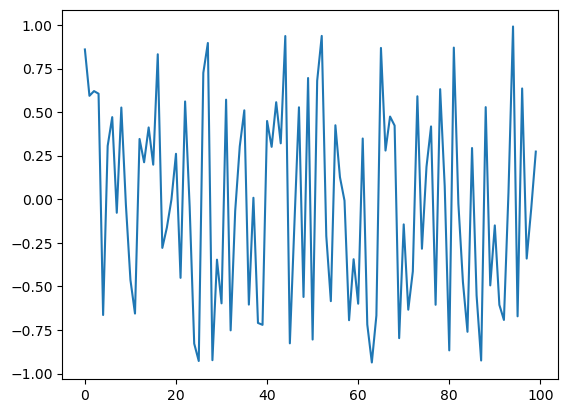

In [148]:
plt.plot(model.weights_1_2[:,4]) 

In [163]:
np.argsort(model.weights_1_2[:,4])[-20:]

array([42, 22, 31, 73,  1,  3,  2, 78, 96, 51, 49, 26, 16,  0, 65, 81, 27,
       44, 52, 94])

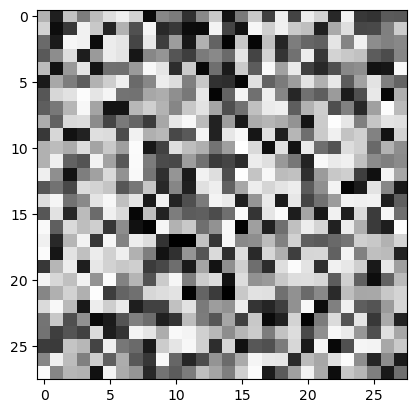

In [200]:
plt.imshow(np.reshape(model.weights_0_1[:,94],[28,28]),cmap='Greys')

Somehow this pattern correlates with part of a 4. I dont see it ;) Note that when i did this exercise with 300 hidden units i did see more digit like weights, but that was probably a symptom of overfitting!

Lets see what gets activated when it saw a 4

In [154]:
y_train[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

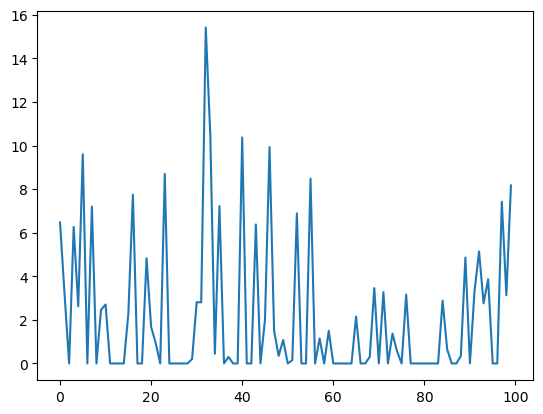

In [201]:
layer_1_test = relu(np.dot(X_train[3],model.weights_0_1) + model.bias_1)
plt.plot(layer_1_test[0])

In [164]:
np.argsort(layer_1_test[0])[-5:]

array([ 5, 46, 40, 33, 32])

the biggest layer hidden neuron that activates is #32 

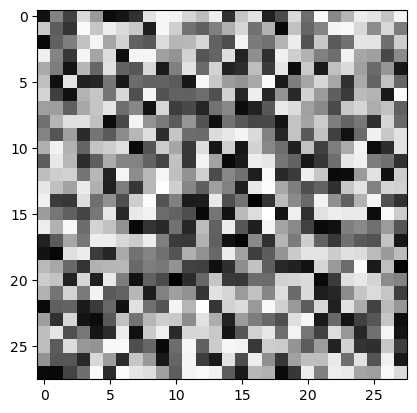

In [203]:
plt.imshow(np.reshape(model.weights_0_1[:,32],[28,28]),cmap='Greys')

Hmm.. . ok i was expecting to see something that would obvious correlate with a 4, but looking at the weight for this unit connecting to the output '4', it comes in with a minus sign.  So it is saying sort of that this particular digit has components that are NOT 4 like, but apparently other components beat this out.

In [166]:
model.weights_1_2[:,4][32]

-0.751943173758571

The biggest non-hib is 40

In [168]:
model.weights_1_2[:,4][40]

0.4489052512509414

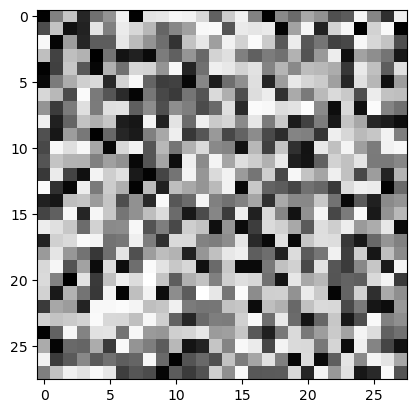

In [204]:
plt.imshow(np.reshape(model.weights_0_1[:,40],[28,28]), cmap = 'Greys')

So it is quite complicated.  The image of the 4 has high correlation with several of the weight vectors which activate several hidden layer units. This particular 4 correlates with non-4 components as well as '4 like' components. 

Let's take a look at one random test sample

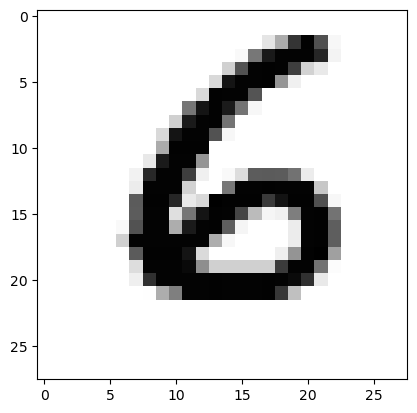

In [205]:
example2 = np.reshape(X_test[402],[28,28])
plt.imshow(example2, cmap = 'Greys')

In [178]:
np.argmax(model.predict(X_test[402]))

6

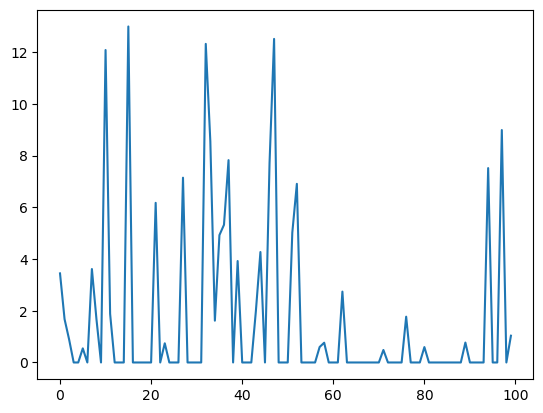

In [174]:
layer_1_test = relu(np.dot(X_test[402],model.weights_0_1) + model.bias_1)
plt.plot(layer_1_test[0])

In [182]:
top4= np.argsort(layer_1_test[0])[-4:]
top4

array([10, 32, 47, 15])

In [185]:
model.weights_1_2[:,6][top4]

array([0.84046099, 0.73655921, 0.90610809, 0.00807979])

Remember these are reversed.

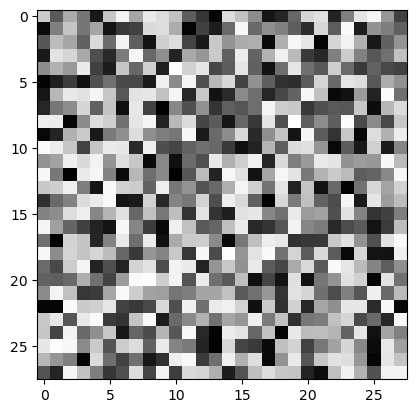

In [206]:
plt.imshow(np.reshape(model.weights_0_1[:,47],[28,28]), cmap='Greys')

I am going to put a pin in this for now.  I was hopping to see more of something 'six' shaped.

## Model with dropout

In [11]:
class DOMNISTNet:
   def __init__(self, hidden_size):
      self.hidden_size = hidden_size
      self.weights_0_1 = 2*np.random.random((28*28,hidden_size)) - 1
      self.weights_1_2 = 2*np.random.random((hidden_size,10)) - 1
      self.bias_1 = np.zeros([1,hidden_size])
      self.bias_2 = np.zeros([1,10])

   def predict(self, X):
      layer_1 = relu(np.dot(X,self.weights_0_1) + self.bias_1)
      return softmax(np.dot(layer_1,self.weights_1_2) + self.bias_2)
   
   def single_epoch_train(self, X, y, alpha, batch_size):
      eps = 10**-9
      indices = [*range(len(y))]
      np.random.shuffle(indices)
      batch_ind = [indices[i:i+batch_size] for i in range(0, len(indices), batch_size)]
      layer_2_error = 0
      for batch in batch_ind:
         layer_2_delta_b = np.zeros([1,10])
         layer_1_2_delta_w = np.zeros([self.hidden_size,10])
         layer_1_delta_b = np.zeros([1,self.hidden_size])
         layer_0_1_delta_w = np.zeros([28*28,self.hidden_size])
         dropout_mask = np.random.randint(2, size = [1, self.hidden_size] )

         # TODO: Vectorize this
         for i in batch:
            layer_0 = X[i:i+1]
            layer_1 = relu(np.dot(layer_0,self.weights_0_1) + self.bias_1) * 2 * dropout_mask
            layer_2 = softmax(np.dot(layer_1,self.weights_1_2) + self.bias_2)
            layer_2_error -= y[i:i+1].dot(np.log(layer_2 + eps).T)
            layer_2_delta =   layer_2 - y[i:i+1]
            layer_1_delta = layer_2_delta.dot(self.weights_1_2.T)*relu2deriv(layer_1)
            layer_1_delta *= dropout_mask
            layer_1_delta_b += layer_1_delta
            layer_2_delta_b += layer_2_delta
            layer_1_2_delta_w += layer_1.T.dot(layer_2_delta)
            layer_0_1_delta_w += layer_0.T.dot(layer_1_delta)
         self.weights_1_2 -= alpha * layer_1_2_delta_w /len(batch)
         self.bias_2 -= alpha*layer_2_delta_b /len(batch)      
         self.weights_0_1 -= alpha * layer_0_1_delta_w /len(batch)
         self.bias_1 -= alpha*layer_1_delta_b / len(batch)
      return layer_2_error


   def sgd(self, X, y, X_val, y_val, alpha, batch_size, epochs):
      for iteration in range(epochs):
         error = self.single_epoch_train(X, y, alpha, batch_size)
         if((iteration + 1) % 10 ==0):
             print(f"Error: {error} -- Val error: {self.evaluate(X_val, y_val)}")


   def evaluate(self, X, y):
      corr = 0
      for i in range(len(y)):
          corr += np.argmax(y[i]) == np.argmax(self.predict(X[i]))
      return corr/len(y)

In [12]:
alpha = 0.0003
np.random.seed(1)
model_do = DOMNISTNet(100)
model_do.sgd(X_train, y_train, X_val, y_val, alpha, 50, 400)

Error: [[76910.6183299]] -- Val error: 0.186
Error: [[67796.66767395]] -- Val error: 0.267
Error: [[61005.58216275]] -- Val error: 0.353
Error: [[54848.07666494]] -- Val error: 0.42
Error: [[49482.09879936]] -- Val error: 0.479
Error: [[45429.12134283]] -- Val error: 0.515
Error: [[40083.28210472]] -- Val error: 0.549
Error: [[37217.34994247]] -- Val error: 0.589
Error: [[34316.83631107]] -- Val error: 0.613
Error: [[31538.81897835]] -- Val error: 0.624
Error: [[29766.71989175]] -- Val error: 0.636
Error: [[26970.27335183]] -- Val error: 0.646
Error: [[25935.72187182]] -- Val error: 0.655
Error: [[24581.45266936]] -- Val error: 0.657
Error: [[23681.04583677]] -- Val error: 0.673
Error: [[22192.22397279]] -- Val error: 0.681
Error: [[21627.76827998]] -- Val error: 0.69
Error: [[20391.23249204]] -- Val error: 0.692
Error: [[19290.30869465]] -- Val error: 0.692
Error: [[18609.49144449]] -- Val error: 0.701
Error: [[17909.0639497]] -- Val error: 0.71
Error: [[17815.96475865]] -- Val error:

In [13]:
model_do.evaluate(X_test,y_test)

0.7604

Does about the same, which is disappointing.

## Vectorize

In [131]:
def softmax_b(x):
    e_x = np.exp(x - np.max(x, axis = -1, keepdims = True))
    return e_x/np.sum(e_x, axis = -1, keepdims= True) 

class SimpMNISTNetV:
   def __init__(self, hidden_size):
      self.hidden_size = hidden_size
      self.weights_0_1 = 2*np.random.random((28*28,hidden_size)) - 1
      self.weights_1_2 = 2*np.random.random((hidden_size,10)) - 1
      self.bias_1 = np.zeros([1,hidden_size])
      self.bias_2 = np.zeros([1,10])

   def predict(self, X):
      layer_1 = relu(np.dot(X,self.weights_0_1) + self.bias_1)
      return softmax(np.dot(layer_1,self.weights_1_2) + self.bias_2)
   
   def single_epoch_train(self, X, y, alpha, batch_size):
      eps = 10**-9
      indices = [*range(len(y))]
      np.random.shuffle(indices)
      batch_ind = [indices[i:i+batch_size] for i in range(0, len(indices), batch_size)]
      layer_2_error = 0
      for batch in batch_ind:
         layer_0 = X[batch]
         layer_1 = relu(np.dot(layer_0,self.weights_0_1) + self.bias_1)
         layer_2 = softmax_b(np.dot(layer_1,self.weights_1_2) + self.bias_2)
         for (i,b) in enumerate(batch):
            layer_2_error -= y[b:b+1].dot(np.log(layer_2[i] + eps).T)
            
         layer_2_delta =  layer_2 - y[batch]  
         layer_1_delta =  layer_2_delta.dot(self.weights_1_2.T)*relu2deriv(layer_1) 
  
         self.weights_1_2 -= alpha * layer_1.T.dot(layer_2_delta)/len(batch) 
         self.bias_2 -=  np.mean(alpha*layer_2_delta, axis = 0)      
         self.weights_0_1 -= alpha * layer_0.T.dot(layer_1_delta)/len(batch) 
         self.bias_1 -=  np.mean(alpha*layer_1_delta, axis = 0) 
      return layer_2_error


   def sgd(self, X, y, X_val, y_val, alpha, batch_size, epochs):
      for iteration in range(epochs):
         error = self.single_epoch_train(X, y, alpha, batch_size)
         if((iteration + 1) % 10 ==0):
             print(f"Error: {error} -- Val error: {self.evaluate(X_val, y_val)}")


   def evaluate(self, X, y):
      corr = 0
      for i in range(len(y)):
          corr += np.argmax(y[i]) == np.argmax(self.predict(X[i]))
      return corr/len(y)


In [134]:
alpha = 0.0003
np.random.seed(1)
model = SimpMNISTNetV(100)
model.sgd(X_train, y_train, X_val, y_val, alpha, 50, 400)

Error: [55158.40450503] -- Val error: 0.221
Error: [41381.18853247] -- Val error: 0.341
Error: [32001.62189283] -- Val error: 0.417
Error: [26070.39206892] -- Val error: 0.487
Error: [22217.22099443] -- Val error: 0.528
Error: [19532.59701891] -- Val error: 0.567
Error: [17538.69386708] -- Val error: 0.591
Error: [16003.76349825] -- Val error: 0.616
Error: [14772.7110725] -- Val error: 0.634
Error: [13753.75868513] -- Val error: 0.649
Error: [12894.50367047] -- Val error: 0.66
Error: [12154.71337619] -- Val error: 0.673
Error: [11512.65614865] -- Val error: 0.688
Error: [10947.04404412] -- Val error: 0.696
Error: [10447.71732924] -- Val error: 0.706
Error: [10000.96422778] -- Val error: 0.713
Error: [9597.8269667] -- Val error: 0.722
Error: [9231.95332301] -- Val error: 0.729
Error: [8900.84878588] -- Val error: 0.738
Error: [8596.85489364] -- Val error: 0.74
Error: [8318.31143315] -- Val error: 0.746
Error: [8060.27235387] -- Val error: 0.75
Error: [7821.8219635] -- Val error: 0.755
E

In [136]:
model.evaluate(X_test, y_test)

0.777

Much faster, but what apain figuring out how to vectorize softmax